In [371]:
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch
import torch.utils
import torch.nn as nn
import torch.utils.data

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from warnings import filterwarnings
filterwarnings("ignore")

In [372]:
# !wget https://www.dropbox.com/s/9vfy1vi6wsfkxyk/creditcard.csv.zip
# !unzip creditcard.csv.zip

In [373]:
device = "cpu"
data = pd.read_csv('creditcard.csv')
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [374]:
data.shape

(284807, 31)

In [375]:
print(f"Количество пропусков: {sum(data.isna().sum())}")

Количество пропусков: 0


In [376]:
data["Class"].value_counts()

Class
0    284315
1       492
Name: count, dtype: int64

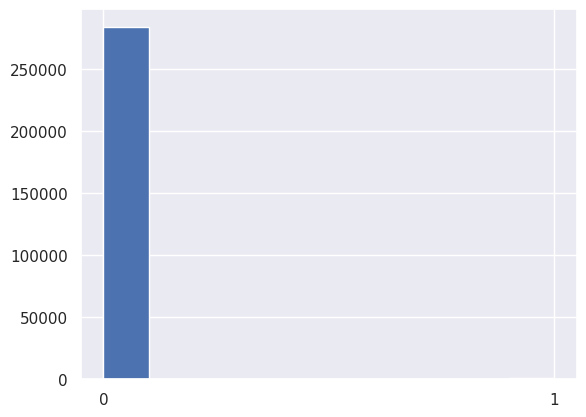

In [377]:
sns.set_theme()
data["Class"].hist()
plt.xticks([0, 1])
plt.show()

In [378]:
X = data[list(data.drop(columns="Class"))]
y = data["Class"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
len(X_train), len(X_test)

(227845, 56962)

In [379]:
weights_for_0 = 1.0 / len(y_train[y_train == 0])
weights_for_1 = 1.0 / len(y_train[y_train == 1])
print(f"w0: {weights_for_0}\nw1: {weights_for_1}")

w0: 4.396551345124884e-06
w1: 0.0025380710659898475


In [380]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X=X_train)
X_test = scaler.transform(X=X_test)
len(X_train), len(X_test)

(227845, 56962)

In [381]:
in_shape = X_train.shape[-1]
hidden_size = 256

In [383]:
class NN(nn.Module):
    def __init__(self):
        super(NN, self).__init__()
        self.linear_1 = nn.Linear(in_features=in_shape, out_features=256)
        self.linear_2 = nn.Linear(in_features=hidden_size, out_features=hidden_size*2)
        self.linear_3 = nn.Linear(in_features=hidden_size*2, out_features=hidden_size)
        self.linear_4 = nn.Linear(in_features=hidden_size, out_features=1)

        self.activation_1 = nn.ReLU() 
        self.activation_2 = nn.Sigmoid()

        self.dropout = nn.Dropout(p=0.3)

    def forward(self, x):
        x = self.linear_1(x)
        x = self.activation_1(x)

        x = self.linear_2(x)
        x = self.activation_1(x)
        x = self.dropout(x)

        x = self.linear_3(x)
        x = self.activation_1(x)
        x = self.dropout(x)
        
        x = self.linear_4(x)
        x = self.activation_2(x)
        return x

        
model = NN()
weight = torch.tensor([weights_for_0, weights_for_1], dtype=torch.float)
loss_fn = nn.BCELoss(weight=weight)
optimizer = torch.optim.Adam(lr=0.01, params=model.parameters())

In [384]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, x, y):
        self.x = torch.from_numpy((x)).to(torch.float32)
        self.y = torch.Tensor(y.to_list()).unsqueeze(1).to(torch.float32)
        
        print(self.x.dtype, self.y.dtype)


    def __len__(self):
        return len(self.x)
    

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]
    

train_dataset = MyDataset(X_train, y_train)
test_dataset = MyDataset(X_test, y_test)
# train_loader = torch.utils.data.DataLoader(train_dataset, shuffle=True, batch_size=256)
# test_loader = torch.utils.data.DataLoader(test_dataset, shuffle=True, batch_size=256)

torch.float32 torch.float32
torch.float32 torch.float32


In [385]:
print(f"data: {test_dataset[0][0]}")
print(f"target: {test_dataset[0][1]}")

data: tensor([ -1.1221,  -8.4395,   5.1825, -12.3132,   6.7147,  -9.9410,  -2.1183,
        -13.4322,   6.3246,  -7.7518, -12.9838,   5.1890, -10.8140,   1.6787,
         -9.7700,   0.3947, -11.2833, -22.5889, -10.0214,   3.8089,  -1.9577,
          1.6250,  -1.5531,  -3.7614,   1.1127,  -2.7076,  -0.9588,  -5.0235,
         -3.1629,   1.0815])
target: tensor([1.])


In [386]:
def accuracy(data, target):
    lst = []
    for i in range(len(data)):
        lst.append(data[i] == target[i])
    return sum(lst) / len(data)

In [387]:
EPOCHS = 1
predict_lst = []



for i in range(EPOCHS):
    model.train()
    train_progress_bar = tqdm(train_dataset, desc=f"Epoch: [{i+1}/{EPOCHS}]")
    for idx, (data, target) in enumerate(train_progress_bar):
        optimizer.zero_grad()
        predict = model(data)
        loss = loss_fn(predict, target)
        loss.backward()
        optimizer.step()

        if idx % 32 == 0:
            train_progress_bar.set_description(f"Epoch: [{i+1}/{EPOCHS}] Loss: {loss.item():.4f}")

    predicts = []
    targets = []
    model.eval()
    test_progress_bar = tqdm(test_dataset, desc=f"Epoch: [{i+1}/{EPOCHS}]")
    with torch.no_grad():
        for idx, (data, target) in enumerate(test_progress_bar):
            predict = model(data)
            predict = torch.argmax(predict, dim=0)
            predicts.append(predict.item())
            targets.append(target.item())

            if idx % 32 == 0:
                test_progress_bar.set_description(f"Epoch: [{i+1}/{EPOCHS}] Accuracy: {accuracy(data=predicts, target=targets)}")

Epoch: [1/1]:   0%|          | 0/891 [00:00<?, ?it/s]


RuntimeError: output with shape [256, 1] doesn't match the broadcast shape [256, 2]